<a href="https://colab.research.google.com/github/Ciela-Institute/Astromatic/blob/main/Astromatic2023/p3_cosmology_and_nbody_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning cosmological parameters and baryonic physics with machine learning
- Contacts: Laurence, Alex, Misha

## Problem description
- Part 1: Given a 2D map of gas density at $z=0$, infer the cosmological parameters $\Omega_m$ and $\sigma_8$.
- Part 2: Given a 2D map of the dark matter distribution at $z=0$, learn how to inpaint the baryons to create a map of the full mass density at $z=0$.

### What’s the main issue?
- Part I: Inferring cosmological parameters from data with the highest possible accuracy is one of the most important goals of modern cosmology. However, this inference problem is very difficult because gravitational and baryonic physics is very non linear, making writing an exact likelihood for this problem intractable. Traditional approaches have focused on using summary statistics like the power spectrum, but this doesn’t make use of a lot of the information in observed maps. With machine learning and deep networks, we can use more information from the data to place tighter constraints on these parameters.
- Part II: For a fixed volume, mass, and spatial resolution, running (magneto-)hydrodynamic simulations is much more computationally expensive than running a gravity-only N-body simulations. This is a significant limitation and the reason why even today, we cannot run hydrodynamic simulations over scales of billions of lightyears, the ones that would be needed to analyze data from cosmological surveys. On the other hand, N-body simulations can be run over such large volumes with enough resolution. One possible way around this is to learn (with deep learning methods) how to inpaint gas and stars into the dark matter field simulated by N-body simulations.

### What is the potential solution to this problem?
- Part I: This can be done with a simple convolutional neural network architecture, and can be tested against published work doing similar tasks (see references).
- Part II: The most straightforward solution to this problem is a UNet-type architecture.

### What data will be used?
The data will be taken from the CAMELS suite of simulations. We have pre-written a function which reduces the resolution of the maps (downsamples) by 4x, but that can be tweaked to produce smaller maps for training.

## Milestones estimators

### Part I
- The first baseline the team should try to accomplish is to compute the power spectrum (using the provided code) over the full-size 256x256 maps and use that as an input to predict $\Omega_m$ and $\sigma_8$ (either with an MLP or a 1D-CNN).
- Try to produce the same point-estimate outputs from the full map (you can try to compress them to make the learning faster; we have provided code to downsample each map into a map that can each be used as a training example).
- Try to output the pdf of the cosmological parameters (i.e. their uncertainties, or even their covariance), and assess the accuracy of the estimated uncertainties.
- Test if the models trained are robust to testing on a different hydro simulation, using the provided SIMBA data. Explore ways to make models robust.

### Part II
- Write a simple UNet architecture to map the dark matter in N-body simulations to the full matter density from the hydro simulations. Some good metrics to explore how good the reconstructions are beyond MSE are: comparing the power spectra of ground truth vs reconstructed maps, and computing the cross-correlation between reconstructed and ground truth maps.
- Explore different kinds of padding and how they affect the reconstructions. Environment is important in predicting the distribution of galaxies, so it could be important to be mindful of this when thinking about how to improve the predictions of your network on the edges of the maps.
- N-body maps do not have all the subgrid physics parameters (the last 4 columns in the params.txt files) required to predict the distribution of baryons. You can think of this as baryon distribution being a stochastic process, and your training set as having multiple samples of possible total mass distributions for a given dark matter distribution. You can extend your model to predict a probability distribution of possible total mass distributions for a given dark matter map.
- Explore robustness to different hydro codes using the provided SIMBA simulations.

## List of 5 papers that might be of help.

- https://arxiv.org/abs/1711.02033 : Estimating Cosmological Parameters from the Dark Matter Distribution
- https://arxiv.org/abs/1811.06533 : Learning to Predict the Cosmological Structure Formation
- https://arxiv.org/abs/2011.05992 : Neural networks as optimal estimators to marginalize over baryonic effects
- https://arxiv.org/abs/2007.10340 : HInet: Generating neutral hydrogen from dark matter with neural networks
- https://arxiv.org/abs/1910.07813 : From Dark Matter to Galaxies with Convolutional Neural Networks

[Camel simulations](https://www.camel-simulations.org/)

[Data description](https://camels.readthedocs.io/en/latest/description.html#suites)

In [1]:
import torch
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 15,
    'figure.figsize': (8, 8),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 15 # for annotate
}
pylab.rcParams.update(params)

DTYPE = torch.float32
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

path_to_hydro_maps = "Data/CAMELS/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy"
path_to_dark_matter_maps = "Data/CAMELS/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy"
path_to_gas_maps = "Data/CAMELS/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy"
path_to_cosmo_params = "Data/CAMELS/params_IllustrisTNG.txt"
FOV = 25 # Mpc / h

drive.mount('/content/drive')
%cd drive/MyDrive/Astromatic2023/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/13PCMYnKn_6oM0iy5oCkFWChed-5qwuos/Astromatic2023


In [2]:
#@title Power spectrum class (run me)
# Helper functions for plotting power spectra and transfer functions
class PowerSpectrum:
    def __init__(self, pixels, bins, dtype=DTYPE):
        assert bins < pixels//2
        self.pixels = pixels
        self.bins = bins
        self.masks = self.build_azimuthal_masks()

    def build_azimuthal_masks(self):
        x = torch.range(-self.pixels//2, self.pixels//2 - 1) + 0.5
        x, y = torch.meshgrid(x, x)
        r = torch.sqrt(x**2 + y**2)
        _, edges = np.histogram(np.arange(self.pixels//2), bins=self.bins)
        masks = torch.zeros(size=[self.bins, self.pixels, self.pixels], dtype=DTYPE)
        for i in range(self.bins):
            mask = ((r > edges[i]) & (r < edges[i + 1])).float()
            masks[i] = mask
        return masks

    def power_spectrum(self, x):
        norm = torch.sqrt(torch.sum(torch.abs(x)**2, dim=(1, 2), keepdims=True))
        x_hat = torch.fft.fftshift(torch.fft.fft2(x/norm))
        ps = torch.zeros(size=[x.shape[0], self.bins], dtype=DTYPE)
        for i in range(self.bins):
            ps[:, i] = torch.sum(torch.abs(x_hat)**2 * self.masks[i][None, ...], dim=(1, 2)) / torch.sum(self.masks[i])
        return ps

    def cross_power_spectrum(self, x, y):
        x_hat = torch.fft.fftshift(torch.fft.fft2((x/torch.sqrt(torch.sum(torch.abs(x)**2, dim=(1, 2), keepdims=True)))))
        y_hat = torch.fft.fftshift(torch.fft.fft2(y/torch.sqrt(torch.sum(torch.abs(y)**2, dim=(1, 2), keepdims=True))))
        ps = torch.zeros(size=[x.shape[0], self.bins], dtype=DTYPE)
        for i in range(self.bins):
            ps[:, i] = torch.sum(torch.abs(torch.conj(x_hat) * y_hat) * self.masks[i][None, ...], dim=(1, 2)) / torch.sum(self.masks[i])
        return ps

    def cross_correlation_coefficient(self, x, y):
        Pxy = self.cross_power_spectrum(x, y)
        Pxx = self.power_spectrum(x)
        Pyy = self.power_spectrum(y)
        gamma = Pxy / torch.sqrt(Pxx * Pyy + 1e-16)
        return gamma

    def transfer_coefficient(self, x, y):
        Pxx = self.power_spectrum(x)
        Pyy = self.power_spectrum(y)
        return Pxx / (Pyy + 1e-16)

# Field to Cosmo Dataset
This dataset is be used to train a neural network that will predict cosmological parameters ($\Omega_m$ and $\sigma_8$) from the power spectrum or the entire fields of dark-matter-only simulations

In [3]:
class FieldtoCosmoDataset(Dataset): # Very important to shuffle this dataset with the dataloader
    def __init__(
        self,
        path_to_dm_only_npy=path_to_dark_matter_maps,
        path_to_params=path_to_cosmo_params,
        downsample:int=0,
        use_power_spectrum=False,
        device=DEVICE):
        """
        downsample: Number of time to downsample the images by a factor of 2 (for each side)
        use_power_spectrum: Returns the power spectrum of the DM field instead
        """
        self.dm_maps = np.load(path_to_dm_only_npy, mmap_mode='r+') # dark matter maps
        self.params = np.loadtxt(path_to_params)[:, :2] # cosmological parameters Omega_m and sigma_8
        self.size = self.dm_maps.shape[0]
        self.downsample = downsample
        self.use_power_spectrum = use_power_spectrum
        self.ps = PowerSpectrum(pixels=256, bins=20)
        f, _ = np.histogram(np.fft.fftfreq(self.ps.pixels)[:self.ps.pixels//2], bins=self.ps.bins)
        self.freq = (f[:-1] + f[1:]) / 2 * self.ps.pixels / FOV

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        x = torch.tensor(self.dm_maps[index]).float().to(DEVICE).unsqueeze(0) # add a channel dimension
        if self.use_power_spectrum:
            x = self.ps.power_spectrum(x)[0]
        else:
            x = F.avg_pool2d(x, 2**self.downsample)

        param_index = (index % self.dm_maps.shape[0]) // 15
        y = torch.tensor(self.params[param_index]).float().to(DEVICE)
        return x, y


# Field to Field Dataset
This dataset is be used to train a neural network that will predict the results
of expensive hydrodynamical simulations like Illustris from the much light dark-matter-only simultion fields.

In [4]:
class FieldtoFieldDataset(Dataset):
    def __init__(
        self,
        path_to_dm_only_npy=path_to_dark_matter_maps,
        path_to_total_mass_npy=path_to_gas_maps,
        pixels=64,
        crop=True,
        device=DEVICE):
        """
        crop: If True, use cropping to reduce image size. If False, use downsampling.
        pixels: The number of pixels of the input and output fields
        """
        self.dm_maps = np.load(path_to_dm_only_npy, mmap_mode='r+')
        self.tm_maps = np.load(path_to_total_mass_npy, mmap_mode='r+')
        self.size = self.dm_maps.shape[0]
        self.crop = crop
        self.pixels = pixels
        assert np.log(pixels)/np.log(2) == int(np.log(pixels)/np.log(2)), "pixels has to be a power of 2!"

    def __len__(self):
        return self.size

    def random_crops(self, img1, img2):
        *_, H, W = img1.shape
        p = self.pixels
        # Randomly choose the starting x and y coordinates for the crop
        start_x = np.random.randint(0, H - p)
        start_y = np.random.randint(0, W - p)
        # Crop the same region in both fields
        crop1 = img1[..., start_y:start_y + p, start_x:start_x + p]
        crop2 = img2[..., start_y:start_y + p, start_x:start_x + p]
        return crop1, crop2

    def __getitem__(self, index):
        x = torch.tensor(self.dm_maps[index]).float().to(DEVICE).view(1, 256, 256) # DM only
        y = torch.tensor(self.tm_maps[index]).float().to(DEVICE).view(1, 256, 256) # hydro sim
        if self.crop:
            x, y = self.random_crops(x, y)
        else:
            k = 256 // self.pixels
            x = F.avg_pool2d(x, k)
            y = F.avg_pool2d(y, k)
        return x, y

# Exploration
Simulations have a comoving volume of $(25\, \mathrm{Mpc}\, h^{-1})^3$

Each map was realized with different cosmological parameters and different seeds.

$\Omega_m \sim \mathcal{U}(0.1,\, 0.6)$

$\sigma_8 \sim \mathcal{U}(0.5, 1)$

<ipython-input-2-1b8ba773e9f9>:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-self.pixels//2, self.pixels//2 - 1) + 0.5
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


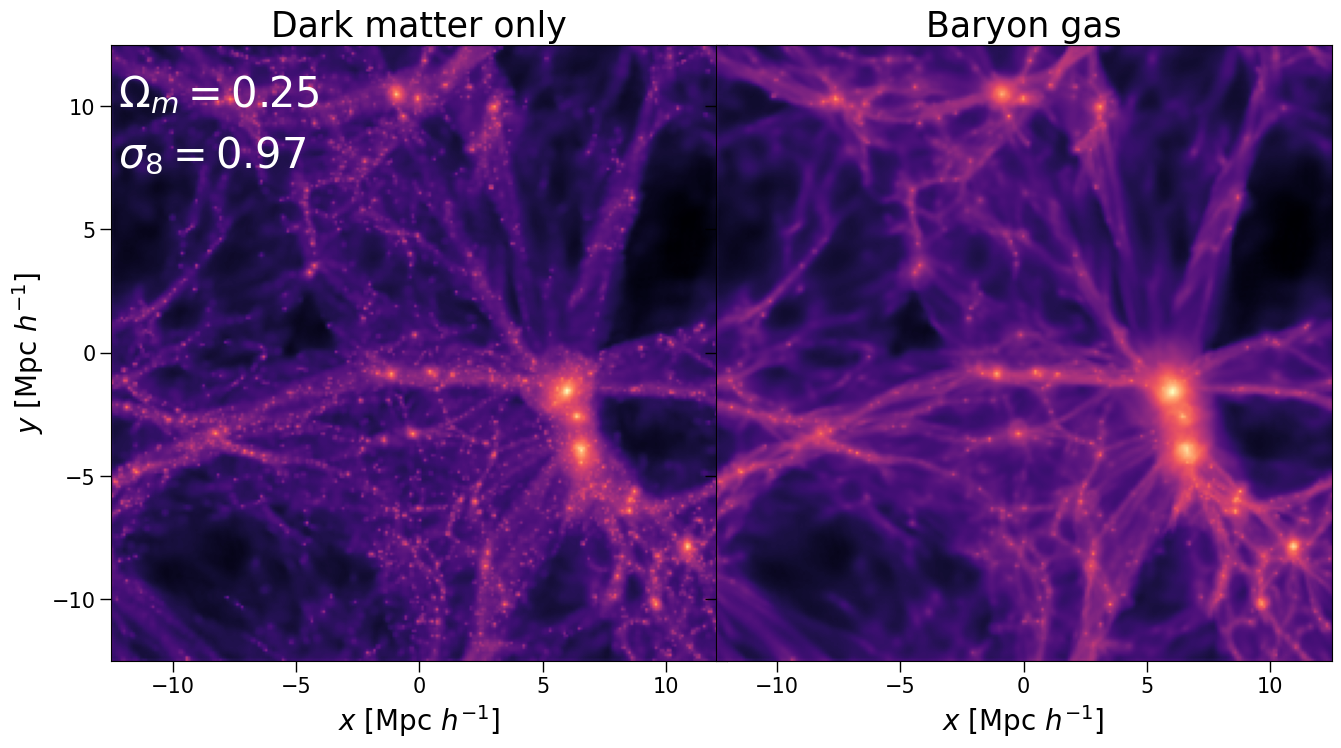

In [5]:
ff_dataset = FieldtoFieldDataset(pixels=256, crop=False) # for the exploration, use the full map (change pixels to 64 or 32 for training)
fc_dataset = FieldtoCosmoDataset()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
extent = [-FOV/2, FOV/2] * 2

index = 14002
x, y = ff_dataset[index]
_, cosmo = fc_dataset[index]
x = x.cpu().squeeze() # Send tensor to cpu for plotting and remove channel dimension
y = y.cpu().squeeze()
cosmo = cosmo.cpu()
im = ax1.imshow(np.log10(x), cmap="magma", origin='lower', extent=extent)
ax1.set_title("Dark matter only")
ax1.set_xlabel("$x$ [Mpc $h^{-1}$]")
ax1.set_ylabel("$y$ [Mpc $h^{-1}$]")
ax1.annotate(r"$\Omega_m = %.2f$" % cosmo[0], xy=(0.01, 0.9), xycoords="axes fraction", color="w", fontsize=30)
ax1.annotate(r"$\sigma_8= %.2f$" % cosmo[1], xy=(0.01, 0.8), xycoords="axes fraction", color="w", fontsize=30)

im = ax2.imshow(np.log10(y), cmap="magma", origin='lower', extent=extent)
ax2.set_title("Baryon gas")
ax2.set_xlabel("$x$ [Mpc $h^{-1}$]")
plt.subplots_adjust(hspace=0, wspace=-0.05);

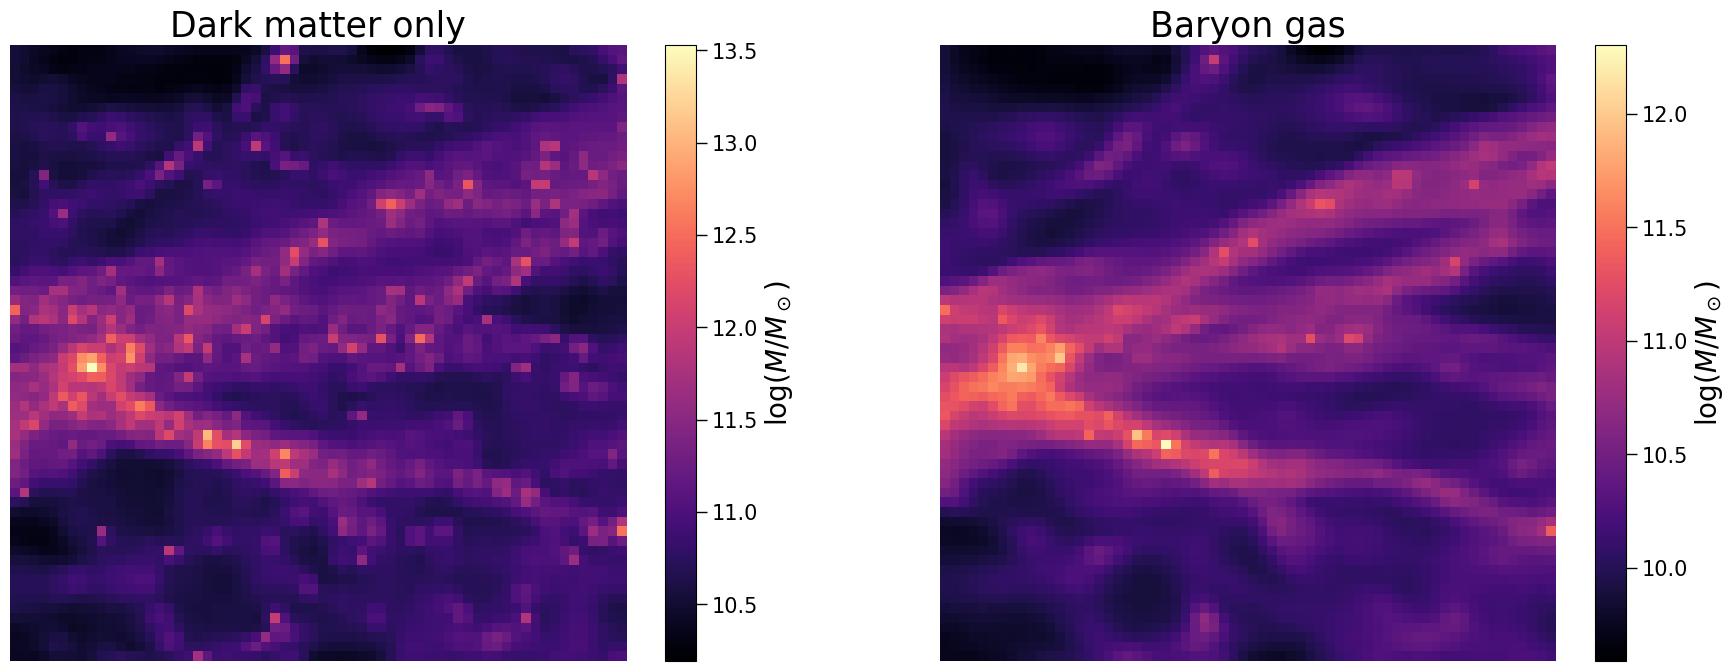

In [6]:
# Get a random crop to see the difference in a close-up
ff_dataset = FieldtoFieldDataset(pixels=64, crop=True)

index = 14002
x, y = ff_dataset[index]
x = x.cpu().squeeze()
y = y.cpu().squeeze()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
im = ax1.imshow(np.log10(x), cmap="magma", origin='lower', extent=extent)
ax1.set_title("Dark matter only")
ax1.set_xlabel("$x$ [Mpc $h^{-1}$]")
ax1.set_ylabel("$y$ [Mpc $h^{-1}$]")
plt.colorbar(im, ax=ax1, label="$\log(M / M_\odot)$");
ax1.axis("off")
ax2.set_yticks([])

im = ax2.imshow(np.log10(y), cmap="magma", origin='lower', extent=extent)
ax2.set_title("Baryon gas")
ax2.set_xlabel("$x$ [Mpc $h^{-1}$]")
ax2.set_ylabel("$y$ [Mpc $h^{-1}$]")
ax2.axis("off")
plt.colorbar(im, ax=ax2, label="$\log(M / M_\odot)$");

# Your solution

In [ ]:
dataset = ...
B = ...
dataloader = DataLoader(dataset, batch_size=B, shuffle=True)